Neste Notebook são abertos dados relativos a imagens de satelite (.nc), conversão desses dados para um formato de dataframe (e divisão desta dataframe em diversas dataframes conforme o dia). Os valores da Temperatura são colocados num formato de Numpy Array (pois queremos que a aplicação do Canny Algorithm seja num Numpy Array). É feita a visualização da imagem relativa à SST para cada dia duma forma despixilizada (contour) e aplicado o canny a esta imagem. 

Para concluir o Canny é aplicado no Numpy array dos valores da temperatura

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os

%matplotlib inline

#### Importação dos dados de Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis

Através da command line eu importei uma base de dados relativa aos ultimos 10 dias dos valores de SST de um dado programa do Copernicus. Trata-se de um ficheiro .nc (netCDF)

No entanto no futuro eu vou querer que o meu programa faça download diretamente dos dados num python script

In [101]:
current_path = os.getcwd()
current_path

'C:\\Users\\asus\\GitHub\\JUNO\\notebooks'

In [102]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'C:\\Users\\asus\\GitHub\\JUNO\\notebooks\\../data'

In [103]:
nc_path = os.path.join(data_folder, "IBI-2019.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [104]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CMEMS IBI-MFC
    institution: Puertos del Estado (PdE) - Mercator-Ocean (MO)
    references: http://marine.copernicus.eu
    title: CMEMS IBI REANALYSIS: DAILY PHYSICAL PRODUCTS 
    easting: longitude
    northing: latitude
    domain_name: IBI12
    FROM_ORIGINAL_FILE__field_type: mean
    field_date: 20191224
    FROM_ORIGINAL_FILE__longitude_min: -19.f
    FROM_ORIGINAL_FILE__longitude_max: 5.f
    FROM_ORIGINAL_FILE__latitude_min: 26.f
    FROM_ORIGINAL_FILE__latitude_max: 56.f
    z_min: 0.50576f
    z_max: 5698.061f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    bulletin_date: 2020-12-01
    bulletin_type: Reanalysis
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m
    dimensions(sizes): time(358)

In [105]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf2 = datadf.reset_index()

In [106]:
datadf2 = datadf2.drop(['depth'], axis=1)
datadf2    #os dados .nc estão agora no formato de uma dataframe

,latitude,time,longitude,thetao
0,35.0,2019-01-01 12:00:00,-19.000000,17.766001
1,35.0,2019-01-01 12:00:00,-18.916666,17.645000
2,35.0,2019-01-01 12:00:00,-18.833334,17.492001
3,35.0,2019-01-01 12:00:00,-18.750000,17.414001
4,35.0,2019-01-01 12:00:00,-18.666666,17.460001
...,...,...,...,...
7320737,45.0,2019-12-24 12:00:00,-5.333334,12.736000
7320738,45.0,2019-12-24 12:00:00,-5.250000,12.770000
7320739,45.0,2019-12-24 12:00:00,-5.166667,13.017000
7320740,45.0,2019-12-24 12:00:00,-5.083334,13.291000


In [107]:
datadf2 = datadf2[['time', 'latitude', 'longitude', 'thetao']]    #reorganizar as colunas da dataframe
datadf2

,time,latitude,longitude,thetao
0,2019-01-01 12:00:00,35.0,-19.000000,17.766001
1,2019-01-01 12:00:00,35.0,-18.916666,17.645000
2,2019-01-01 12:00:00,35.0,-18.833334,17.492001
3,2019-01-01 12:00:00,35.0,-18.750000,17.414001
4,2019-01-01 12:00:00,35.0,-18.666666,17.460001
...,...,...,...,...
7320737,2019-12-24 12:00:00,45.0,-5.333334,12.736000
7320738,2019-12-24 12:00:00,45.0,-5.250000,12.770000
7320739,2019-12-24 12:00:00,45.0,-5.166667,13.017000
7320740,2019-12-24 12:00:00,45.0,-5.083334,13.291000


In [110]:
#Para analisarmos os dados relativos ao dia 2019-12-14
dia10 = datadf2[datadf2['time'] == '2019-12-01 12:00:00']
dia10

,time,latitude,longitude,thetao
56446,2019-12-01 12:00:00,35.0,-19.000000,20.309000
56447,2019-12-01 12:00:00,35.0,-18.916666,20.441002
56448,2019-12-01 12:00:00,35.0,-18.833334,20.590000
56449,2019-12-01 12:00:00,35.0,-18.750000,20.723000
56450,2019-12-01 12:00:00,35.0,-18.666666,20.813000
...,...,...,...,...
7316850,2019-12-01 12:00:00,45.0,-5.333334,14.459000
7316851,2019-12-01 12:00:00,45.0,-5.250000,14.553000
7316852,2019-12-01 12:00:00,45.0,-5.166667,14.601000
7316853,2019-12-01 12:00:00,45.0,-5.083334,14.633000


#### Plot do Mapa da SST para o dia 14 despixilizado

In [111]:
dia10 = dia10.drop(['time'], axis=1)
dia10

,latitude,longitude,thetao
56446,35.0,-19.000000,20.309000
56447,35.0,-18.916666,20.441002
56448,35.0,-18.833334,20.590000
56449,35.0,-18.750000,20.723000
56450,35.0,-18.666666,20.813000
...,...,...,...
7316850,45.0,-5.333334,14.459000
7316851,45.0,-5.250000,14.553000
7316852,45.0,-5.166667,14.601000
7316853,45.0,-5.083334,14.633000


In [112]:
Temp = dia10.pivot_table(index='longitude', columns='latitude', values='thetao').T.values

long_unique = np.sort(dia10['longitude'].unique())
lat_unique = np.sort(dia10['latitude'].unique())
X, Y = np.meshgrid(long_unique, lat_unique)

In [113]:
Temp.shape #por este Temp dentro do Canny

(121, 169)

In [114]:
Temp_10 = pd.DataFrame(Temp).round(5)
Temp_10

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,20.309,20.441000,20.590000,20.723000,20.813000,20.836000,20.812000,20.767000,20.732,20.658001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20.320,20.461000,20.608999,20.708000,20.764999,20.778999,20.750999,20.712999,20.677,20.545000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.355,20.511999,20.660999,20.719000,20.735001,20.726000,20.698000,20.674999,20.597,20.363001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.395,20.575001,20.716000,20.733999,20.718000,20.702000,20.683001,20.635000,20.455,20.249001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.448,20.653999,20.757000,20.749001,20.731001,20.715000,20.670000,20.538000,20.350,20.287001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,13.449,13.481000,13.456000,13.534000,13.704000,13.899000,14.118000,14.325000,14.488,14.572000,...,13.748,13.791,13.829,13.904,14.001,14.075,14.155,14.283,14.438,14.577
117,13.562,13.598000,13.527000,13.508000,13.512000,13.602000,13.809000,14.065000,14.291,14.457000,...,14.009,14.046,14.062,14.089,14.116,14.155,14.256,14.405,14.539,14.644
118,13.754,13.844000,13.828000,13.766000,13.656000,13.625000,13.776000,14.032000,14.253,14.400000,...,14.062,14.122,14.160,14.186,14.205,14.260,14.375,14.501,14.598,14.711
119,13.867,14.000000,14.012000,13.930000,13.770000,13.686000,13.798000,14.014000,14.213,14.347000,...,13.890,14.018,14.140,14.227,14.290,14.376,14.488,14.578,14.642,14.753


<ipython-input-115-83a9f69ee9b1>:21: UserWarning: No contour levels were found within the data range.
  cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)


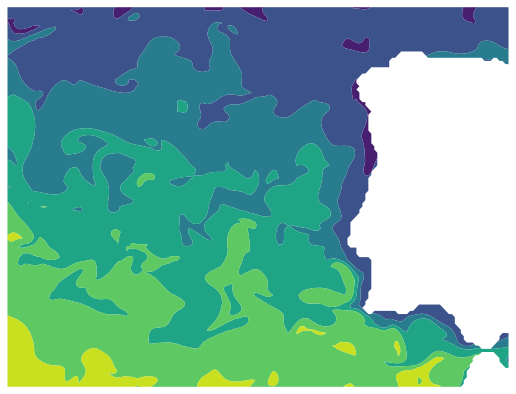

In [115]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = 9,7 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Define levels in z-axis where we want lines to appear
levels = np.array([-0.4,-0.2,0,0.2,0.4])   #como os valores estão super baixos não aparece as linhas a separarem valores no mapa   
#levels = np.array([13, 14, 15, 16, 17, 18, 19, 20])  #permite definir no mapa linhas que separam zonas de diferentes temperaturas

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,Temp, len(levels), cmap=cm.viridis)

# Set all level lines to black
line_colors = ['black' for l in cpf.levels]     

# Make plot and customize axes
cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off')         #Para remover da imagem os labels com a longitude e latitude
#plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
#plt.title('SST Map 14 December 2019')
 

images_folder = os.path.join(current_path, "../images")
plt.savefig(os.path.join(images_folder, "SST_July10.png"))

### Aplicar Canny Edge Detector a imagem (.png) do dia 14 obtida através do Seaborn

No entanto o meu objectivo não é aplicar o Canny edge detector a imagens (.png), pois ao gravar a imagem eu perco as dimensões verdadeiras da matriz da Temperatura (a imagem fica nomeadamente com 3 dimensões (RGB))

O objetivo é aplicar o Canny a um numpy array que é uma representação dessa imagem.

In [116]:
SST_july10 = cv2.imread(os.path.join(images_folder, "SST_July10.png"))
SST_july10

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [117]:
SST_july10.shape

(504, 648, 3)

In [118]:
x = os.path.join(images_folder, "SST_July14.png")
x

'C:\\Users\\asus\\GitHub\\JUNO\\notebooks\\../images\\SST_July14.png'

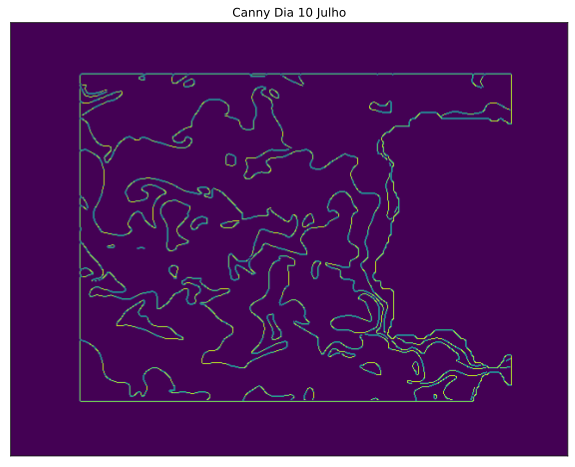

In [119]:
canny = cv2.Canny(SST_july10, 100, 180, L2gradient=False, apertureSize=3)
#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

plt.rcParams["figure.figsize"] = (10,8)

plt.imshow(canny)    #'gray'-> parametro para por a preto e branco
plt.title('Canny Dia 10 Julho')
plt.xticks([])
plt.yticks([])
    
plt.show()
#Aplicação do Canny diretamente à imagem previamente guardada

### Aplicar o Canny Algorithm ao numpy array 

Agora vamos aplicar o Canny algorithm no numpy de dimensoes (121, 169) que representa os valores de temperatura

In [33]:
canny = cv2.Canny(Temp, 100, 200)

#Eu quero fazer um Canny não da imagem que gravei mas da matriz que dá origem a essa imagem 
#Pq quando eu converto para imagem (.png) as dimensões fodem-se todas

#Verificar se o canny aceita Null values e se tenho de converter os valores de temperatura para uma escala entre 0 e 255

# Dá erro pq o Numpy Temp tem de ser do tipo uint8. CV_8U is just an alias for the datatype uint8.

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


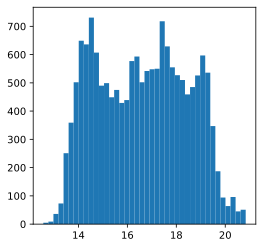

In [121]:
plt.hist(Temp.flatten(), bins=40);
plt.rcParams["figure.figsize"] = 4,4

#### --------------------------------------------------------------------------------------------------------------
#### Usar um array com o formato uint8 (Valores na gama normal entre 0 e 20)
#### --------------------------------------------------------------------------------------------------------------

In [122]:
Temp_aux = Temp.copy() #criar um numpy auxiliar que é uma cópia do numpy Temp
Temp_aux

array([[20.309    , 20.441002 , 20.59     , ...,        nan,        nan,
               nan],
       [20.32     , 20.461    , 20.609001 , ...,        nan,        nan,
               nan],
       [20.355    , 20.512001 , 20.661    , ...,        nan,        nan,
               nan],
       ...,
       [13.754    , 13.844    , 13.828    , ..., 14.501    , 14.598    ,
        14.711    ],
       [13.867001 , 14.       , 14.012    , ..., 14.578    , 14.642    ,
        14.753    ],
       [13.805    , 13.949    , 13.9800005, ..., 14.601    , 14.633    ,
        14.728001 ]], dtype=float32)

In [123]:
Temp_aux.shape

(121, 169)

In [124]:
#Converter o array para o formato uint8
Temp_aux = Temp_aux.astype(np.uint8)

In [125]:
Temp_aux

array([[20, 20, 20, ...,  0,  0,  0],
       [20, 20, 20, ...,  0,  0,  0],
       [20, 20, 20, ...,  0,  0,  0],
       ...,
       [13, 13, 13, ..., 14, 14, 14],
       [13, 14, 14, ..., 14, 14, 14],
       [13, 13, 13, ..., 14, 14, 14]], dtype=uint8)

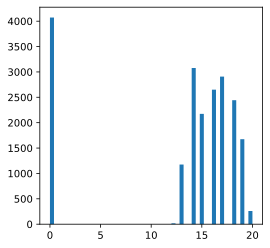

In [126]:
#Para verificarmos que os valores estão de facto entre 0 e 20
plt.hist(Temp_aux.flatten(), bins=50);
plt.rcParams["figure.figsize"] = 4, 4

In [127]:
Temp_aux = np.flipud(Temp_aux)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux

array([[13, 13, 13, ..., 14, 14, 14],
       [13, 14, 14, ..., 14, 14, 14],
       [13, 13, 13, ..., 14, 14, 14],
       ...,
       [20, 20, 20, ...,  0,  0,  0],
       [20, 20, 20, ...,  0,  0,  0],
       [20, 20, 20, ...,  0,  0,  0]], dtype=uint8)

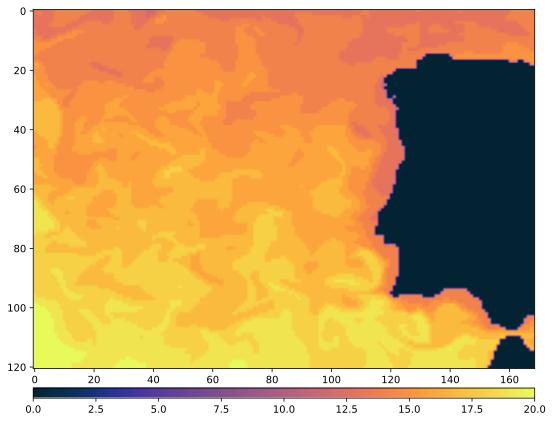

In [129]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
import cmocean
im = plt.imshow(Temp_aux, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (9,9)
plt.colorbar(im, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.show()

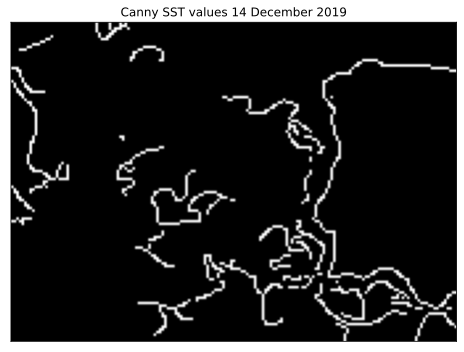

In [130]:
canny = cv2.Canny(Temp_aux, 3.5, 7, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

#Canny aplicado ao numpy array

#### --------------------------------------------------------------------------------------------------------------
#### Usar um array com formato uint8, com valores entre 0 e 255 (MAIS CORRETO)
#### --------------------------------------------------------------------------------------------------------------

In [131]:
# Matriz de temperatura em que os valores estão entre 0 e 255
Temp_aux5 = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')
Temp_aux5

array([[238, 242, 247, ...,   0,   0,   0],
       [239, 243, 248, ...,   0,   0,   0],
       [240, 245, 249, ...,   0,   0,   0],
       ...,
       [ 36,  39,  38, ...,  59,  62,  66],
       [ 40,  44,  44, ...,  62,  64,  67],
       [ 38,  42,  43, ...,  62,  63,  66]], dtype=uint8)

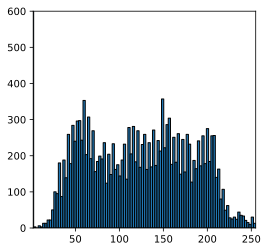

In [133]:
#Para verificarmos que os valores estão de facto entre 0 e 255
plt.hist(Temp_aux5.flatten(), bins=100, edgecolor='black');
plt.xlim([2, 255])
plt.ylim([0, 600])
plt.rcParams["figure.figsize"] = 4, 4

In [134]:
Temp_aux5 = np.flipud(Temp_aux5)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux5

array([[ 38,  42,  43, ...,  62,  63,  66],
       [ 40,  44,  44, ...,  62,  64,  67],
       [ 36,  39,  38, ...,  59,  62,  66],
       ...,
       [240, 245, 249, ...,   0,   0,   0],
       [239, 243, 248, ...,   0,   0,   0],
       [238, 242, 247, ...,   0,   0,   0]], dtype=uint8)

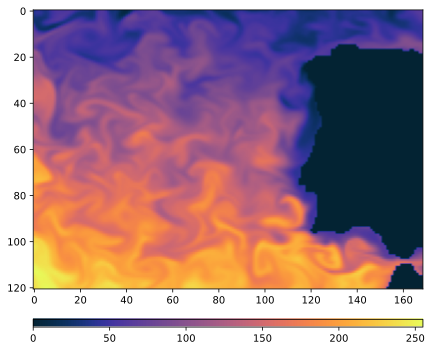

In [136]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.show()

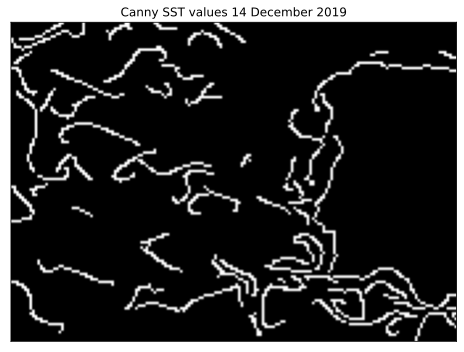

In [175]:
canny3 = cv2.Canny(Temp_aux5, 70, 140, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny3, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

#o problema que esta a surgir é que como convertemos todos os valores do array da temperatura para a gama entre 0 e 255, os valores que eram 0 (terra) estão muito perto dos valores de temperatura mais baixos do oceano o que faz nomeadamente com que as margens continentais não apareçam 

### Resultados the canny:
    15 May -> lixo (quase não se conseguem detetar edges)
    30 May -> Mau (algumas edges na costa Sul portuguesa)
    10 June -> Medio/Mau (algumas edges mas a costa portuguesa fica mal definida por vezes)
    30 June -> Lixo (quase não se detetam edges)
    July -> bad results
    10 Agosto -> Medio/Mau (algumas edges mas a costa portuguesa fica mal definida por vezes)
    30 Agosto -> Medio (detetam-se edges na costa Sul portuguesa)
    15 Setembro -> médio (detetam-se edges ao longo da costa mas a costa esta mal definida em alguns sitios)
    30 Setembro -> médio (detetam-se varias edges mas a costa esta mal definida em alguns sitios)
    15 Outubro -> médio/mau (detetam-se edges ao longo da costa mas a costa esta mal definida em alguns sitios)
    30 Outubro -> médio/bom (detetam-se edges e a costa encontra-se relativamente bem definida)

In [ ]:

# Tentar aplicar grayscale previamente às imagens ->  Não funciona porque os valores do array têm de estar no formato uint8

### Para Interpretação

<ipython-input-436-6b48266ad7c0>:36: UserWarning: No contour levels were found within the data range.
  cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)


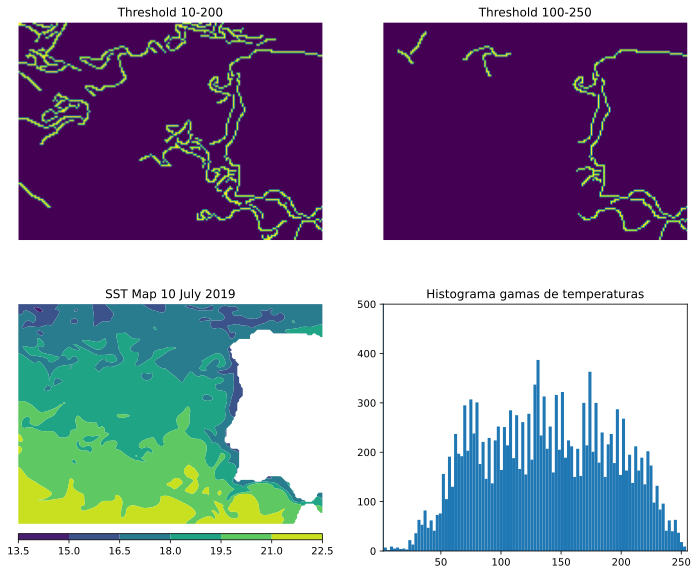

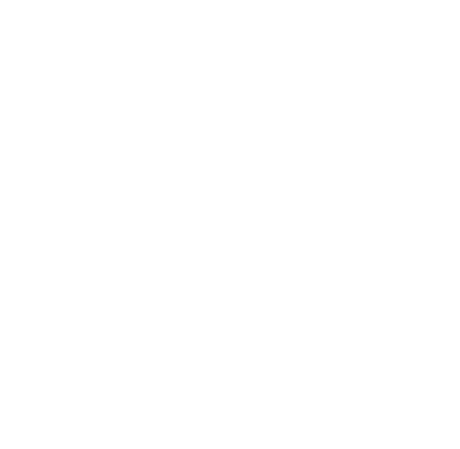

In [436]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definição dos parametros do canny
canny_1 = cv2.Canny(Temp_aux5, 10, 200, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_1)
plt.axis('off')
plt.title("Threshold 10-200");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
#Definição dos parametros do canny
canny_2 = cv2.Canny(Temp_aux5, 100, 250, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_2)
plt.axis('off')
plt.title("Threshold 100-250");


# Adds a subplot to show the image

ax = fig.add_subplot(rows, columns, 3)
# Generate a color mapping of the levels we've specified
cpf = ax.contourf(X,Y,Temp, len(levels), cmap=cm.viridis)
# Make plot and customize axes
cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 10 July 2019');


# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
histograma = plt.hist(Temp_aux5.flatten(), bins=100);
plt.xlim([2, 255])
plt.ylim([0, 500])
# showing image
plt.title("Histograma gamas de temperaturas");
plt.show(histograma);
plt.axis('off');

    
#plt.show()

### Apply Gaussian Filter previously

No paper de Madagascar eles dizem aplicar um gaussian filter às imagens antes de aplicar o Canny Algorithm (to omit small scale variability)

In [178]:
from scipy.ndimage import gaussian_filter

In [179]:
Temp_gauss = Temp_aux5.copy()
Temp_gauss

array([[ 38,  42,  43, ...,  62,  63,  66],
       [ 40,  44,  44, ...,  62,  64,  67],
       [ 36,  39,  38, ...,  59,  62,  66],
       ...,
       [240, 245, 249, ...,   0,   0,   0],
       [239, 243, 248, ...,   0,   0,   0],
       [238, 242, 247, ...,   0,   0,   0]], dtype=uint8)

In [180]:
Temp_gauss = gaussian_filter(Temp_gauss, sigma=1)
Temp_gauss

array([[ 39,  40,  40, ...,  61,  63,  64],
       [ 38,  39,  39, ...,  59,  62,  64],
       [ 35,  36,  36, ...,  57,  61,  63],
       ...,
       [241, 244, 247, ...,   0,   0,   0],
       [240, 243, 247, ...,   0,   0,   0],
       [239, 242, 246, ...,   0,   0,   0]], dtype=uint8)

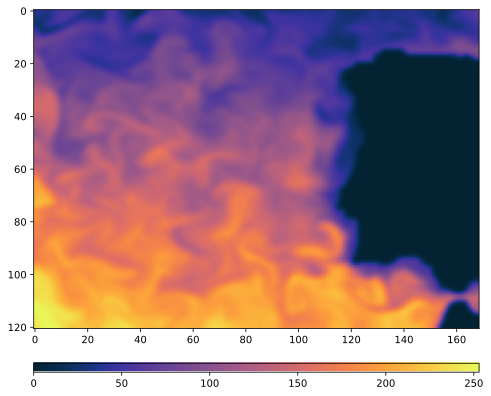

In [181]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.show()

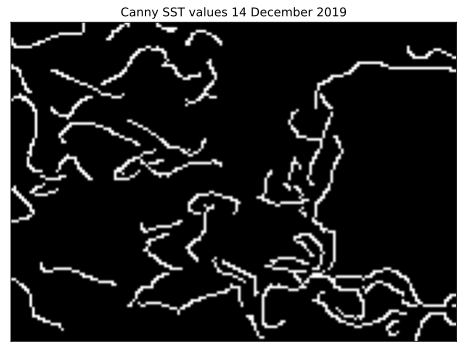

In [184]:
canny7 = cv2.Canny(Temp_gauss, 50, 100, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny7, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

# -------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------
### Tentar compreender a que valores de temperatura verdadeiros correspondem os valores da gama 0-255

In [437]:
Temperatura_real = Temp.copy()
Temperatura_real

array([[21.711   , 21.793   , 21.906   , ...,       nan,       nan,
              nan],
       [21.848   , 21.902   , 21.98    , ...,       nan,       nan,
              nan],
       [21.93    , 21.973   , 22.021   , ...,       nan,       nan,
              nan],
       ...,
       [16.316   , 16.254   , 16.203   , ..., 17.147   , 17.127   ,
        17.18    ],
       [16.219   , 16.051   , 15.852   , ..., 17.233   , 17.205   ,
        17.168   ],
       [15.906   , 15.566   , 15.297001, ..., 17.328001, 17.304   ,
        17.243   ]], dtype=float32)

In [438]:
#converter os NaN values to zero
Temperatura_real = np.where(np.isnan(Temperatura_real), 0, Temperatura_real)
Temperatura_real

array([[21.711   , 21.793   , 21.906   , ...,  0.      ,  0.      ,
         0.      ],
       [21.848   , 21.902   , 21.98    , ...,  0.      ,  0.      ,
         0.      ],
       [21.93    , 21.973   , 22.021   , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [16.316   , 16.254   , 16.203   , ..., 17.147   , 17.127   ,
        17.18    ],
       [16.219   , 16.051   , 15.852   , ..., 17.233   , 17.205   ,
        17.168   ],
       [15.906   , 15.566   , 15.297001, ..., 17.328001, 17.304   ,
        17.243   ]], dtype=float32)

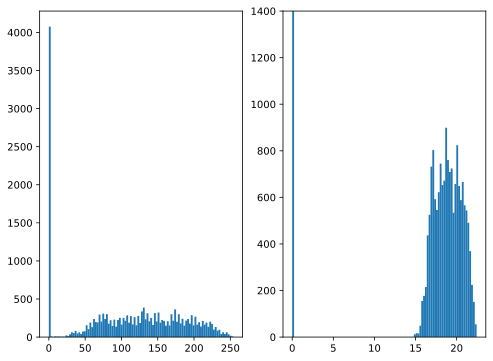

In [440]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(Temp_aux5.flatten(), bins=100);
ax[1].hist(Temperatura_real.flatten(), bins=100);
#plt.xlim([2, 255])
plt.ylim([0, 1400])
plt.rcParams["figure.figsize"] = 8, 6

# ---------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------
### Código para que dada uma dataframe, esta seja dividida em várias dataframes consoante a data

Os dados que eu vou extrair do satelite serão referentes a vários dias diferentes portanto para facilitar o posterior processamento dos dados, esta função vai me permitir dividir a dataframe original em diversas dataframes conforme a data

In [441]:
datadf2

,time,latitude,longitude,thetao
0,2019-01-01 12:00:00,35.0,-19.000000,17.766001
1,2019-01-01 12:00:00,35.0,-18.916666,17.645000
2,2019-01-01 12:00:00,35.0,-18.833334,17.492001
3,2019-01-01 12:00:00,35.0,-18.750000,17.414001
4,2019-01-01 12:00:00,35.0,-18.666666,17.460001
...,...,...,...,...
7320737,2019-12-24 12:00:00,45.0,-5.333334,12.736000
7320738,2019-12-24 12:00:00,45.0,-5.250000,12.770000
7320739,2019-12-24 12:00:00,45.0,-5.166667,13.017000
7320740,2019-12-24 12:00:00,45.0,-5.083334,13.291000


In [442]:
#converter a coluna time para string (pode simplificar)
datadf2['time']=datadf2['time'].astype(str)

In [443]:
#Criar uma lista com as diferentes datas
unique_dates = datadf2['time'].unique()
list_dates = list(unique_dates)
list_dates

['2019-01-01 12:00:00',
 '2019-01-02 12:00:00',
 '2019-01-03 12:00:00',
 '2019-01-04 12:00:00',
 '2019-01-05 12:00:00',
 '2019-01-06 12:00:00',
 '2019-01-07 12:00:00',
 '2019-01-08 12:00:00',
 '2019-01-09 12:00:00',
 '2019-01-10 12:00:00',
 '2019-01-11 12:00:00',
 '2019-01-12 12:00:00',
 '2019-01-13 12:00:00',
 '2019-01-14 12:00:00',
 '2019-01-15 12:00:00',
 '2019-01-16 12:00:00',
 '2019-01-17 12:00:00',
 '2019-01-18 12:00:00',
 '2019-01-19 12:00:00',
 '2019-01-20 12:00:00',
 '2019-01-21 12:00:00',
 '2019-01-22 12:00:00',
 '2019-01-23 12:00:00',
 '2019-01-24 12:00:00',
 '2019-01-25 12:00:00',
 '2019-01-26 12:00:00',
 '2019-01-27 12:00:00',
 '2019-01-28 12:00:00',
 '2019-01-29 12:00:00',
 '2019-01-30 12:00:00',
 '2019-01-31 12:00:00',
 '2019-02-01 12:00:00',
 '2019-02-02 12:00:00',
 '2019-02-03 12:00:00',
 '2019-02-04 12:00:00',
 '2019-02-05 12:00:00',
 '2019-02-06 12:00:00',
 '2019-02-07 12:00:00',
 '2019-02-08 12:00:00',
 '2019-02-09 12:00:00',
 '2019-02-10 12:00:00',
 '2019-02-11 12:

In [444]:
n_unique = datadf2['time'].nunique()
n_unique    #nº de datas diferentes que há na dataframe

358

In [445]:
splits = list(datadf2.groupby("time"))   # divide a dataframe de acordo com a coluna 'time' e agrupa a informação numa lista

In [446]:
d = {}
for i in range(n_unique):
    for time in list_dates:
        d[time] = pd.DataFrame(splits[i][1])

In [447]:
d

{'2019-01-01 12:00:00':                         time  latitude  longitude     thetao
 60333    2019-12-24 12:00:00      35.0 -19.000000  19.176001
 60334    2019-12-24 12:00:00      35.0 -18.916666  19.051001
 60335    2019-12-24 12:00:00      35.0 -18.833334  19.094002
 60336    2019-12-24 12:00:00      35.0 -18.750000  19.167999
 60337    2019-12-24 12:00:00      35.0 -18.666666  19.235001
 ...                      ...       ...        ...        ...
 7320737  2019-12-24 12:00:00      45.0  -5.333334  12.736000
 7320738  2019-12-24 12:00:00      45.0  -5.250000  12.770000
 7320739  2019-12-24 12:00:00      45.0  -5.166667  13.017000
 7320740  2019-12-24 12:00:00      45.0  -5.083334  13.291000
 7320741  2019-12-24 12:00:00      45.0  -5.000000  13.390000
 
 [20449 rows x 4 columns],
 '2019-01-02 12:00:00':                         time  latitude  longitude     thetao
 60333    2019-12-24 12:00:00      35.0 -19.000000  19.176001
 60334    2019-12-24 12:00:00      35.0 -18.916666  19.05

In [448]:
for key in d.keys():
    d[key] = datadf2[:][datadf2.time == key]

In [449]:
d['2019-07-14 12:00:00']  

,time,latitude,longitude,thetao
32786,2019-07-14 12:00:00,35.0,-19.000000,21.832001
32787,2019-07-14 12:00:00,35.0,-18.916666,21.792999
32788,2019-07-14 12:00:00,35.0,-18.833334,21.754002
32789,2019-07-14 12:00:00,35.0,-18.750000,21.695000
32790,2019-07-14 12:00:00,35.0,-18.666666,21.608002
...,...,...,...,...
7293190,2019-07-14 12:00:00,45.0,-5.333334,20.280001
7293191,2019-07-14 12:00:00,45.0,-5.250000,20.292999
7293192,2019-07-14 12:00:00,45.0,-5.166667,20.317001
7293193,2019-07-14 12:00:00,45.0,-5.083334,20.327000


In [450]:
d['2019-07-14 12:00:00'].info()    #trata-se duma dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20449 entries, 32786 to 7293194
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       20449 non-null  object 
 1   latitude   20449 non-null  float64
 2   longitude  20449 non-null  float64
 3   thetao     16377 non-null  float32
dtypes: float32(1), float64(2), object(1)
memory usage: 718.9+ KB


# ----------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------
### Transformar as coordenadas (longitude e latitude) numa tupple de Pixels (x,y)

In [451]:
#Criar 2 novas colunas X e Y que sejam os pixels correspondentes

lons = dia10["longitude"].astype("float32").unique()
lats = dia10["latitude"].astype("float32").unique()
lons.sort()
lats.sort()
def get_pixels(lons, lats):
    pixels = {}
    for x, lon in enumerate(lons):
        for y, lat in enumerate(lats):
            pixels[(lon, lat)] = (x, y)
    return pixels
def get_x(lon, lat, pixels):
    return pixels[(lon, lat)][0]
def get_y(lon, lat, pixels):
    return pixels[(lon, lat)][1]
pixels = get_pixels(lons, lats)
dia10["x"] = dia10.apply(lambda row: get_x(row["longitude"], row["latitude"], pixels), axis=1)
dia10["y"] = dia10.apply(lambda row: get_y(row["longitude"], row["latitude"], pixels), axis=1)

In [452]:
#Converter as colunas x e y para uma nova coluna no formato de tupple
dia10['Pixels'] = dia10[['x', 'y']].apply(tuple, axis=1)

In [453]:
dia10

,latitude,longitude,thetao,x,y,Pixels
51038,35.0,-19.000000,21.711000,0,0,"(0, 0)"
51039,35.0,-18.916666,21.792999,1,0,"(1, 0)"
51040,35.0,-18.833334,21.906000,2,0,"(2, 0)"
51041,35.0,-18.750000,22.035000,3,0,"(3, 0)"
51042,35.0,-18.666666,22.127001,4,0,"(4, 0)"
...,...,...,...,...,...,...
7311442,45.0,-5.333334,17.224001,164,120,"(164, 120)"
7311443,45.0,-5.250000,17.299000,165,120,"(165, 120)"
7311444,45.0,-5.166667,17.328001,166,120,"(166, 120)"
7311445,45.0,-5.083334,17.304001,167,120,"(167, 120)"


# --------------------------------------------------------------------------------------